In [338]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from random import shuffle
import pandas as pd
import numpy as np
import pysubgroup as ps
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Preprocessing

Splitting data to test/train set and overall preprocessing

In [2]:
df_train = pd.read_csv('adult.data' ,sep=',', index_col = False, 
                names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                        'hours-per-week', 'native-country', 'income'])

In [3]:
df_test = pd.read_csv('adult.test' ,sep=',', index_col = False, 
                names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                        'hours-per-week', 'native-country', 'income']).drop(0)

In [4]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
y_train = df_train['income']
X_train = df_train.drop('income', axis = 1)

In [6]:
X_train = pd.get_dummies(X_train)
y_train = pd.get_dummies(y_train)

In [7]:
y_train = y_train.drop([' <=50K'], axis = 1)
y_train = y_train.rename(columns = {' >50K': 'income >50K'})

In [8]:
df_test['age']=pd.to_numeric(df_test['age'])

In [9]:
y_test = df_test['income']
X_test = df_test.drop('income', axis = 1)

In [10]:
X_test['native-country_ Holand-Netherlands'] = 0

In [11]:
X_test = pd.get_dummies(X_test)
y_test = pd.get_dummies(y_test)

In [12]:
y_test = y_test.drop([' <=50K.'], axis = 1)
y_test = y_test.rename(columns = {' >50K.': 'income >50K'})

# RandomForest

Fitting standard RF model 

In [13]:
rf = RandomForestClassifier()

In [14]:
rf.fit(X_train,y_train)

C:\Users\Vladimir\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vladimir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
y_test_pred = rf.predict(X_test)

In [16]:
y_test_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [17]:
np.mean(y_test['income >50K']==y_test_pred)

0.7857625452982003

# PART 1 SAME-AS-RF METHOD

Following you may find 1-st proposed method.

# DT Tables

Computing corresponding data tables for each decision tree:

In [19]:
target_list = []
for i in rf.estimators_:
    target_list.append(i.predict(X_train) == rf.predict(X_train))

In [20]:
table_list = []
for i in target_list:
    X_temp = X_train.copy()
    X_temp['target'] = i
    table_list.append(X_temp)

Saving tables:

In [21]:
#j = 1
#for i in table_list:
#    i.to_csv('DT'+str(j)+'.csv', sep = ',') 
#    j+=1

# Subgrop Discovery

Extracting rules:

In [21]:
rules_list = []

In [22]:
for i in table_list:
    target = ps.NominalTarget('target', True)
    searchspace = ps.create_selectors(i, ignore = ['target'])
    task = ps.SubgroupDiscoveryTask(i, target, searchspace, result_set_size = 20, depth=5, qf=ps.ChiSquaredQF())
    result = ps.BeamSearch().execute(task)
    rules_list.append(result)

In [283]:
rules_list_mod = []
for i in rules_list:
    rules_list_mod.append(i[:5])

Extracting values from resulting strings with regular expressions:

In [288]:
rules = []
dt_num = 0
for dt_list in rules_list_mod:
    
    dt_num+=1
    
    for j in dt_list:
        
        strength = j[0]
        
        rulestring = re.search(r'D: .+>>', str(j[1])).group()[3:-2]
        
        rulesplit = re.split(r' AND ', rulestring)
        rulesplit_list = []
        
        for i in rulesplit:
            if not (re.search(r'=', i)):
                rulestring_name = re.search(r'.*: ', i).group()[:-2]
                rulestring_value_full = re.search(r': .*', i).group()[2:]
                rulestring_value_left = re.search(r'.*:', rulestring_value_full).group()[1:-1]
                rulestring_value_right = re.search(r':.*', rulestring_value_full).group()[1:-1]
                rulestring_value = (rulestring_value_left, rulestring_value_right)
            else:
                rulestring_name = re.search(r'.*=', i).group()[:-1]
                rulestring_value = re.search(r'=.*', i).group()[1:]
                
            rulesplit_list.append(rulestring_name)
            rulesplit_list.append(rulestring_value)
            
            
        rule_seq = [dt_num, strength]
        for i in rulesplit_list:
            rule_seq.append(i)
        rules.append(rule_seq)

In [289]:
rules_df = pd.DataFrame(rules, columns = ['dt', 'strength', 'name_1', 'value_1', 'name_2', 'value_2', 'name_3', 'value_3','name_4', 'value_4','name_5', 'value_5'])

In [290]:
rules_df

,dt,strength,name_1,value_1,name_2,value_2,name_3,value_3,name_4,value_4,name_5,value_5
0,1,1184.855542,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 11th,0,education_ 7th-8th,0
1,1,1164.229392,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 7th-8th,0,education_ 5th-6th,0
2,1,1163.548269,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 9th,0,education_ 7th-8th,0
3,1,1161.585245,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 7th-8th,0,native-country_ Mexico,0
4,1,1161.529727,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",occupation_ Other-service,0,capital-loss,"(0, 155)",education_ 7th-8th,0
5,2,1193.993266,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",education_ 9th,0,occupation_ Farming-fishing,0,native-country_ Mexico,0
6,2,1192.717759,marital-status_ Married-civ-spouse,1,education_ 11th,0,capital-gain,"(0, 114)",education_ 9th,0,native-country_ Mexico,0
7,2,1190.613793,marital-status_ Married-civ-spouse,1,education_ 11th,0,capital-gain,"(0, 114)",occupation_ Farming-fishing,0,native-country_ Mexico,0
8,2,1187.949361,marital-status_ Married-civ-spouse,1,education_ 11th,0,capital-gain,"(0, 114)",occupation_ Farming-fishing,0,education_ 9th,0
9,2,1186.175363,marital-status_ Married-civ-spouse,1,education_ 10th,0,capital-gain,"(0, 114)",education_ 9th,0,native-country_ Mexico,0


In [291]:
rules_cdf = rules_df.drop_duplicates(['name_1', 'value_1', 'name_2', 'value_2', 'name_3', 'value_3','name_4', 'value_4','name_5', 'value_5'], keep='first')

In [292]:
rules_cdf['strength'] = rules_cdf['strength'].apply(lambda x: float(x))

In [293]:
rules_cdf = rules_cdf.sort_values(by = 'strength', ascending = False)

In [294]:
rules_cdf = rules_cdf.dropna(0)

# Correcting predictions

Generating true/false masks from rules:

In [295]:
l = []
k = 1
for _,i in rules_cdf.iterrows():
    
    maskflag = False
    
    for j in range(1,6):
        intervalflag = False
        
        name_str = 'name_'+str(j)
        value_str = 'value_'+str(j)
        
        name = str(i[name_str])
        
        if type(i[value_str])==tuple:
            intervalflag = True
            value_left = int(i[value_str][0])
            value_right = int(i[value_str][1])
        else:
            value = int(i[value_str])
            
        if maskflag & intervalflag:
            mask = (mask) & (X_test[name]>=value_left) & (X_test[name]<value_right)
        elif maskflag & (not intervalflag):
            mask = (mask) & (X_test[name]==value)
        elif (not maskflag) & intervalflag:
            mask = (X_test[name]>=value_left)&(X_test[name]<value_right)
            maskflag = True
        else:
            mask = (X_test[name]==value)
            maskflag = True

    l.append((int(i['dt']), mask, k))
        
    k = k+1

Validation:

In [318]:
def validate(n):

    eval_summary = []
    for j in range(n):
        shuffle(l)
        tbl = []
        tbl.append((np.mean(y_test['income >50K']==rf.predict(X_test)), 0))
        y_test_pred = pd.Series(rf.predict(X_test))
        y_test_pred.index+=1
        stack = l[0][1]
        for i in l:
            pred = pd.Series(rf.estimators_[int(i[0])-1].predict(X_test))
            pred.index+=1
            y_test_pred[i[1]] = pred[i[1]]
            acc = np.mean(y_test['income >50K']==y_test_pred)
            stack = stack | i[1]
            expl = np.mean(stack)
            tbl.append((acc, expl, str(i[2])))
            if expl == 1:
                break
        brief = pd.DataFrame(tbl, columns = ['accuracy', 'explainability', '#rule'])

        #linear approx
        dots = np.linspace(0,0.9,19)
        eval_dots = []
        for i in dots:
            for j, _ in brief.iterrows():
                if i<brief['explainability'][j]:
                    dt = brief['explainability'][j]-brief['explainability'][j-1]
                    d = brief['accuracy'][j]-brief['accuracy'][j-1]
                    a = i-brief['explainability'][j-1]
                    res = brief['accuracy'][j-1] + a*d/dt
                    eval_dots.append(res)
                    break
        eval_summary.append(np.array(eval_dots))
    
    return dots,eval_summary

In [339]:
N = 100

In [340]:
dots, eval_summary = validate(N)

In [341]:
eval_df= pd.DataFrame(eval_summary)

Mean:

In [342]:
eval_mean = eval_df.mean(axis = 0)

Variance (0.95 confidence interval for mean with Student 100 df distribution quantile):

In [358]:
eval_var = 1.984*np.sqrt(eval_df.var(axis = 0))/math.sqrt(N)

Mean DT accuracy:

In [359]:
val = []
for i in range(10):
    y_est_pred = rf.estimators_[i].predict(X_test)
    val.append(np.mean(y_test['income >50K']==y_est_pred))
dt_val_avg = np.mean(val)

RF accuracy:

In [360]:
rf_val = np.mean(rf.predict(X_test)==y_test['income >50K'])

### Resulting plot:

In [361]:
result_df = pd.DataFrame({"Proposed Method":eval_mean, "Dots":dots})

In [362]:
result_df['Random Forest'] = rf_val

In [363]:
result_df['Average Decision Tree'] = dt_val_avg

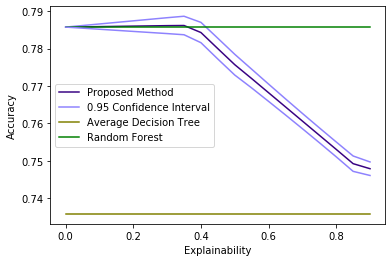

In [449]:
sns.lineplot(dots,eval_mean, color = '#380282')
sns.lineplot(dots,eval_mean+eval_var, color='#8e82fe')
sns.lineplot(dots,dt_val_avg, color = 'olive')
sns.lineplot(dots,rf_val, color = 'green')
sns.lineplot(dots,eval_mean-eval_var, color='#8e82fe')
plt.xlabel('Explainability')
plt.ylabel('Accuracy')
plt.legend(('Proposed Method', '0.95 Confidence Interval', 'Average Decision Tree', 'Random Forest'))

# PART 2 SAME-AS-GROUND-TRUTH METHOD

Following you may find the 2nd method (it differs from the 1st only on the stage of computing tables for decision trees, as we use different heuristics).

# DT Tables

In [385]:
target_list = []
for i in rf.estimators_:
    target_list.append(i.predict(X_train) == y_train['income >50K'])

In [386]:
table_list = []
for i in target_list:
    X_temp = X_train.copy()
    X_temp['target'] = i
    table_list.append(X_temp)

Saving tables:

In [387]:
#j = 1
#for i in table_list:
#    i.to_csv('DT'+str(j)+'.csv', sep = ',') 
#    j+=1

# Subgrop Discovery

In [21]:
rules_list = []

In [388]:
for i in table_list:
    target = ps.NominalTarget('target', True)
    searchspace = ps.create_selectors(i, ignore = ['target'])
    task = ps.SubgroupDiscoveryTask(i, target, searchspace, result_set_size = 5, depth=5, qf=ps.ChiSquaredQF())
    result = ps.BeamSearch().execute(task)
    rules_list.append(result)

In [396]:
rules_list_mod = rules_list[10:]

Extracting values from resulting strings with regular expressions:

In [399]:
rules = []
dt_num = 0
for dt_list in rules_list_mod:
    
    dt_num+=1
    
    for j in dt_list:
        
        strength = j[0]
        
        rulestring = re.search(r'D: .+>>', str(j[1])).group()[3:-2]
        
        rulesplit = re.split(r' AND ', rulestring)
        rulesplit_list = []
        
        for i in rulesplit:
            if not (re.search(r'=', i)):
                rulestring_name = re.search(r'.*: ', i).group()[:-2]
                rulestring_value_full = re.search(r': .*', i).group()[2:]
                rulestring_value_left = re.search(r'.*:', rulestring_value_full).group()[1:-1]
                rulestring_value_right = re.search(r':.*', rulestring_value_full).group()[1:-1]
                rulestring_value = (rulestring_value_left, rulestring_value_right)
            else:
                rulestring_name = re.search(r'.*=', i).group()[:-1]
                rulestring_value = re.search(r'=.*', i).group()[1:]
                
            rulesplit_list.append(rulestring_name)
            rulesplit_list.append(rulestring_value)
            
            
        rule_seq = [dt_num, strength]
        for i in rulesplit_list:
            rule_seq.append(i)
        rules.append(rule_seq)

In [400]:
rules_df = pd.DataFrame(rules, columns = ['dt', 'strength', 'name_1', 'value_1', 'name_2', 'value_2', 'name_3', 'value_3','name_4', 'value_4','name_5', 'value_5'])

In [401]:
rules_df

,dt,strength,name_1,value_1,name_2,value_2,name_3,value_3,name_4,value_4,name_5,value_5
0,1,1222.668481,marital-status_ Married-civ-spouse,1,education_ 7th-8th,0,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 11th,0
1,1,1211.344926,marital-status_ Married-civ-spouse,1,education_ 7th-8th,0,capital-gain,"(0, 114)",capital-loss,"(0, 155)",native-country_ Mexico,0
2,1,1203.756666,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",education_ 9th,0,capital-loss,"(0, 155)",education_ 7th-8th,0
3,1,1203.542716,marital-status_ Married-civ-spouse,1,capital-loss,"(0, 155)",capital-gain,"(0, 114)",education_ 11th,0,native-country_ Mexico,0
4,1,1198.699473,marital-status_ Married-civ-spouse,1,education_ 7th-8th,0,capital-gain,"(0, 114)",capital-loss,"(0, 155)",education_ 1st-4th,0
5,2,1247.383774,marital-status_ Married-civ-spouse,1,education_ 9th,0,capital-gain,"(0, 114)",education_ 11th,0,native-country_ Mexico,0
6,2,1243.776749,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",education_ 10th,0,education_ 9th,0,native-country_ Mexico,0
7,2,1237.390633,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",education_ 10th,0,native-country_ Mexico,0,education_ 11th,0
8,2,1233.384057,marital-status_ Married-civ-spouse,1,education_ 9th,0,capital-gain,"(0, 114)",native-country_ Mexico,0,education_ 7th-8th,0
9,2,1233.038619,marital-status_ Married-civ-spouse,1,capital-gain,"(0, 114)",education_ 10th,0,education_ 9th,0,education_ 11th,0


In [402]:
rules_cdf = rules_df.drop_duplicates(['name_1', 'value_1', 'name_2', 'value_2', 'name_3', 'value_3','name_4', 'value_4','name_5', 'value_5'], keep='first')

In [403]:
rules_cdf['strength'] = rules_cdf['strength'].apply(lambda x: float(x))

C:\Users\Vladimir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [404]:
rules_cdf = rules_cdf.sort_values(by = 'strength', ascending = False)

In [405]:
rules_cdf = rules_cdf.dropna(0)

# Correcting predictions

Generating true/false masks from rules:

In [406]:
l = []
k = 1
for _,i in rules_cdf.iterrows():
    
    maskflag = False
    
    for j in range(1,6):
        intervalflag = False
        
        name_str = 'name_'+str(j)
        value_str = 'value_'+str(j)
        
        name = str(i[name_str])
        
        if type(i[value_str])==tuple:
            intervalflag = True
            value_left = int(i[value_str][0])
            value_right = int(i[value_str][1])
        else:
            value = int(i[value_str])
            
        if maskflag & intervalflag:
            mask = (mask) & (X_test[name]>=value_left) & (X_test[name]<value_right)
        elif maskflag & (not intervalflag):
            mask = (mask) & (X_test[name]==value)
        elif (not maskflag) & intervalflag:
            mask = (X_test[name]>=value_left)&(X_test[name]<value_right)
            maskflag = True
        else:
            mask = (X_test[name]==value)
            maskflag = True

    l.append((int(i['dt']), mask, k))
        
    k = k+1

Validation:

In [407]:
def validate(n):

    eval_summary = []
    for j in range(n):
        shuffle(l)
        tbl = []
        tbl.append((np.mean(y_test['income >50K']==rf.predict(X_test)), 0))
        y_test_pred = pd.Series(rf.predict(X_test))
        y_test_pred.index+=1
        stack = l[0][1]
        for i in l:
            pred = pd.Series(rf.estimators_[int(i[0])-1].predict(X_test))
            pred.index+=1
            y_test_pred[i[1]] = pred[i[1]]
            acc = np.mean(y_test['income >50K']==y_test_pred)
            stack = stack | i[1]
            expl = np.mean(stack)
            tbl.append((acc, expl, str(i[2])))
            if expl == 1:
                break
        brief = pd.DataFrame(tbl, columns = ['accuracy', 'explainability', '#rule'])

        #linear approx
        dots = np.linspace(0,0.9,19)
        eval_dots = []
        for i in dots:
            for j, _ in brief.iterrows():
                if i<brief['explainability'][j]:
                    dt = brief['explainability'][j]-brief['explainability'][j-1]
                    d = brief['accuracy'][j]-brief['accuracy'][j-1]
                    a = i-brief['explainability'][j-1]
                    res = brief['accuracy'][j-1] + a*d/dt
                    eval_dots.append(res)
                    break
        eval_summary.append(np.array(eval_dots))
    
    return dots,eval_summary

In [408]:
N = 100

In [409]:
dots_2, eval_summary_2 = validate(N)

In [410]:
eval_df_2= pd.DataFrame(eval_summary_2)

Mean:

In [411]:
eval_mean_2 = eval_df_2.mean(axis = 0)

Variance (0.95 confidence interval for mean with Student 100 df distribution quantile):

In [412]:
eval_var_2 = 1.984*np.sqrt(eval_df_2.var(axis = 0))/math.sqrt(N)

Mean DT accuracy:

In [413]:
val = []
for i in range(10):
    y_est_pred = rf.estimators_[i].predict(X_test)
    val.append(np.mean(y_test['income >50K']==y_est_pred))
dt_val_avg_2 = np.mean(val)

RF accuracy:

In [414]:
rf_val_2 = np.mean(rf.predict(X_test)==y_test['income >50K'])

### Resulting plot:

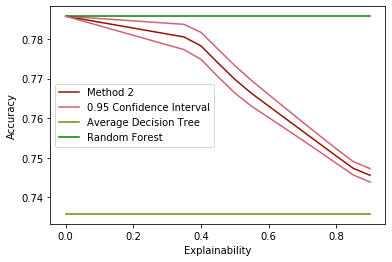

In [446]:
sns.lineplot(dots_2,eval_mean_2, color = '#8f1402')
sns.lineplot(dots_2,eval_mean_2+eval_var_2, color='#cf6275')
sns.lineplot(dots_2,dt_val_avg_2, color = 'olive')
sns.lineplot(dots_2,rf_val_2, color = 'green')
sns.lineplot(dots_2,eval_mean_2-eval_var_2, color='#cf6275')
plt.xlabel('Explainability')
plt.ylabel('Accuracy')
plt.legend(('Method 2', '0.95 Confidence Interval', 'Average Decision Tree', 'Random Forest'))

### Comparing plots for 2 methods:

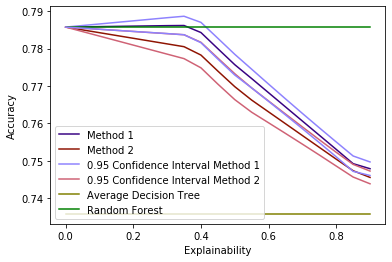

In [448]:
sns.lineplot(dots,eval_mean, color = '#380282')
sns.lineplot(dots_2,eval_mean_2, color = '#8f1402')
sns.lineplot(dots,eval_mean+eval_var, color='#8e82fe')
sns.lineplot(dots_2,eval_mean_2+eval_var_2, color='#cf6275')
sns.lineplot(dots_2,dt_val_avg_2, color = 'olive')
sns.lineplot(dots_2,rf_val_2, color = 'green')
sns.lineplot(dots_2,eval_mean_2-eval_var_2, color='#cf6275')
sns.lineplot(dots,eval_mean-eval_var, color='#8e82fe')

plt.xlabel('Explainability')
plt.ylabel('Accuracy')
plt.legend(('Method 1', 'Method 2', '0.95 Confidence Interval Method 1', '0.95 Confidence Interval Method 2', 'Average Decision Tree', 'Random Forest'))

RF parameters:

In [450]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

Single run example:

In [452]:
shuffle(l)
tbl = []
tbl.append((np.mean(y_test['income >50K']==rf.predict(X_test)), 0))
y_test_pred = pd.Series(rf.predict(X_test))
y_test_pred.index+=1
stack = l[0][1]
for i in l:
    pred = pd.Series(rf.estimators_[int(i[0])-1].predict(X_test))
    pred.index+=1
    y_test_pred[i[1]] = pred[i[1]]
    acc = np.mean(y_test['income >50K']==y_test_pred)
    stack = stack | i[1]
    expl = np.mean(stack)
    tbl.append((acc, expl, str(i[2])))
    if expl == 1:
            break
    brief = pd.DataFrame(tbl, columns = ['accuracy', 'explainability', '#rule'])

In [453]:
brief

,accuracy,explainability,#rule
0,0.785763,0.000000,None
1,0.787114,0.377311,17
2,0.786930,0.392543,23
3,0.785824,0.399607,22
4,0.799459,0.399853,6
5,0.751674,0.883730,26
6,0.741539,0.884467,16
7,0.751858,0.915300,37
8,0.741109,0.915300,34
9,0.751182,0.915300,15
